**Jose Acosta**&nbsp;  
**Python Developer | Data Engineering • Applied Data Science | Quantitative Systems**  

📧 jose.trader89@hotmail.com  
📱 +58 0412 302 0280


# Mean Reversion Trading Strategy Demo 📈

## Interactive demonstration of the Ornstein-Uhlenbeck mean reversion strategy

This notebook walks you through:
1. **Data Collection** - Fetching real market data
2. **Parameter Estimation** - Using Maximum Likelihood Estimation
3. **Signal Generation** - Creating buy/sell signals
4. **Backtesting** - Evaluating strategy performance
5. **Visualization** - Interactive plots and analysis

## 🚀 Setup and Imports

In [16]:
# Install required packages if running in Colab
import sys
if 'google.colab' in sys.modules:
    !pip install yfinance

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ All imports successful!")
print("🚀 Ready to start the demo!")

✅ All imports successful!
🚀 Ready to start the demo!


## 📊 Step 1: Data Collection

Let's fetch real market data for a stock. You can change the ticker and date range below:

[*********************100%***********************]  1 of 1 completed

📈 Fetching data for AAPL from 2022-01-01 to 2024-01-01...
✅ Successfully fetched 501 data points
📊 Price range: $123.42 - $196.67


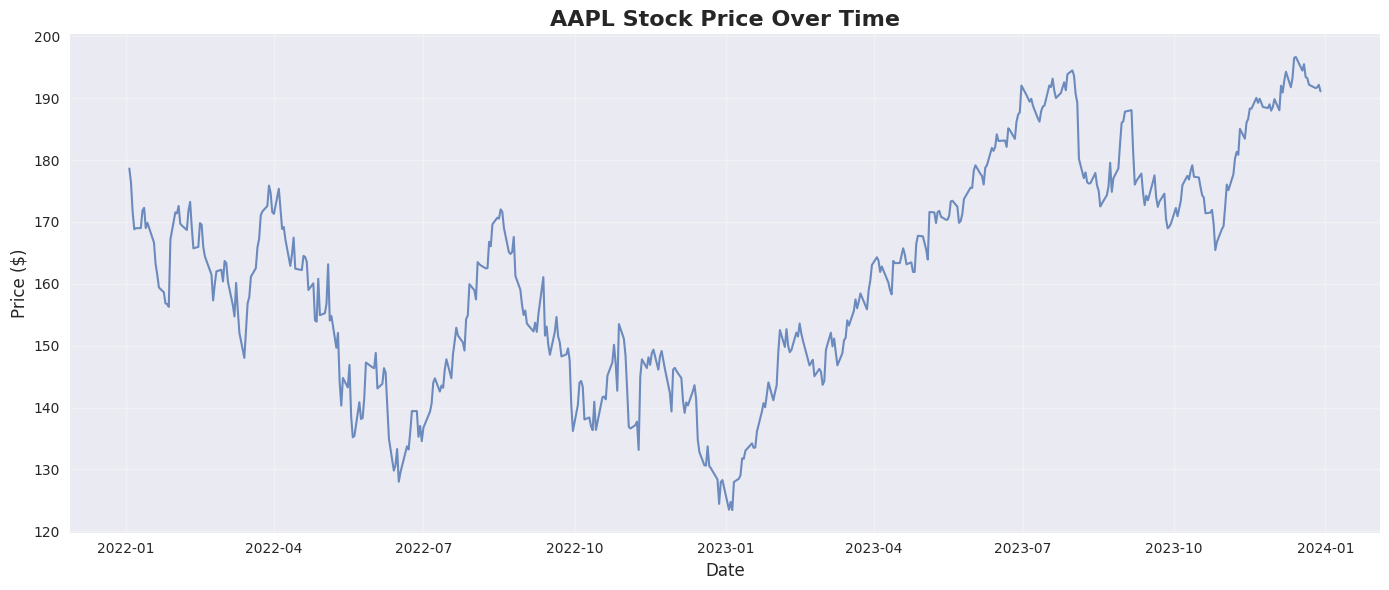

In [17]:
# Configuration
TICKER = "AAPL"  # Change this to any ticker you want
START_DATE = "2022-01-01"
END_DATE = "2024-01-01"

print(f"📈 Fetching data for {TICKER} from {START_DATE} to {END_DATE}...")

# Fetch data
data = yf.download(TICKER, start=START_DATE, end=END_DATE)
prices = data['Close'].values

print(f"✅ Successfully fetched {len(prices)} data points")
print(f"📊 Price range: ${prices.min():.2f} - ${prices.max():.2f}")

# Plot the raw data
plt.figure(figsize=(14, 6))
plt.plot(data.index, prices, linewidth=1.5, alpha=0.8)
plt.title(f'{TICKER} Stock Price Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 🔢 Step 2: Parameter Estimation Using Maximum Likelihood

Now we'll estimate the Ornstein-Uhlenbeck process parameters:
- **μ (mu)**: Long-term mean
- **θ (theta)**: Speed of mean reversion
- **σ (sigma)**: Volatility

In [18]:
# 🔢 Step 2 – Parameter Estimation Using Maximum Likelihood

def estimate_ou_parameters(prices):
    """
    Estimate Ornstein-Uhlenbeck parameters (mu, theta, sigma) via
    Maximum-Likelihood Estimation.

    Parameters
    ----------
    prices : array-like
        1-D array of closing prices.

    Returns
    -------
    mu, theta, sigma : float
        Long-term mean, mean-reversion speed, and volatility.
    """
    # Ensure `prices` is a 1-D NumPy vector
    prices = np.asarray(prices, dtype=float).ravel()

    dt = 1 / 252  # daily data ⇒ 252 trading days per year

    def ou_log_likelihood(params):
        mu, theta, sigma = params

        # Penalise invalid parameter regions
        if theta <= 0 or sigma <= 0:
            return 1e6

        X_diff = np.diff(prices)          # ΔXₜ
        X_lag  = prices[:-1]              # Xₜ₋₁
        expected_diff = theta * (mu - X_lag) * dt
        residuals     = X_diff - expected_diff

        var       = sigma**2 * dt
        log_like  = (
            -0.5 * len(residuals) * np.log(2 * np.pi * var)
            -0.5 * np.sum(residuals**2) / var
        )
        return -log_like  # minimise ⇒ maximise log-likelihood

    # Initial guesses
    mu_init    = prices.mean()
    theta_init = 0.1
    sigma_init = np.std(np.diff(prices)) / np.sqrt(dt)

    result = minimize(
        ou_log_likelihood,
        x0=[mu_init, theta_init, sigma_init],
        method="L-BFGS-B",
        bounds=[(None, None), (1e-6, None), (1e-6, None)],
    )
    return result.x  # (mu, theta, sigma)


# --- Run the estimation ----------------------------------------------------
print("🔍 Estimating Ornstein-Uhlenbeck parameters…")
mu_est, theta_est, sigma_est = estimate_ou_parameters(prices)

print("\n📊 Estimated Parameters:")
print(f"   μ (Long-term mean): ${mu_est:.2f}")
print(f"   θ (Mean-reversion speed): {theta_est:.4f}")
print(f"   σ (Volatility): ${sigma_est:.2f}")

print("\n💡 Interpretation:")
print(f"   – The stock tends to revert to ${mu_est:.2f}")
print(f"   – Half-life of mean reversion: {np.log(2) / theta_est:.1f} days")
print(f"   – Daily volatility: ${sigma_est * np.sqrt(1/252):.2f}")


🔍 Estimating Ornstein-Uhlenbeck parameters…

📊 Estimated Parameters:
   μ (Long-term mean): $163.89
   θ (Mean-reversion speed): 2.7019
   σ (Volatility): $44.54

💡 Interpretation:
   – The stock tends to revert to $163.89
   – Half-life of mean reversion: 0.3 days
   – Daily volatility: $2.81


## 📈 Step 3: Generate Trading Signals

Based on the estimated parameters, we'll generate buy and sell signals:

📊 Signal Summary:
   Buy signals : 228 (45.5% of days)
   Sell signals: 201 (40.1% of days)
   Threshold   : $4.21


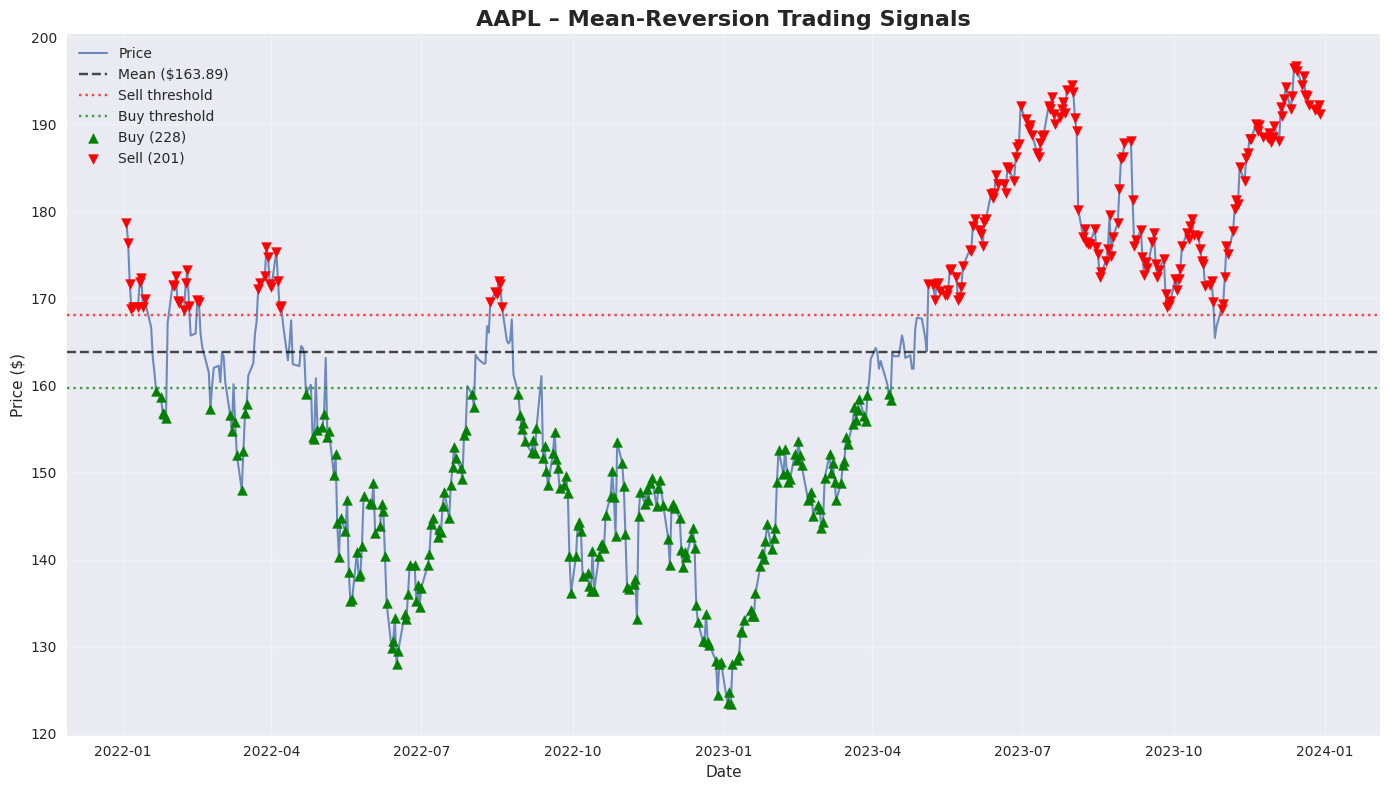

In [19]:
# 📈 Step 3 – Generate Trading Signals and Plot
def generate_signals(prices, mu, sigma, threshold_multiplier: float = 1.5):
    """
    Generate boolean buy/sell signals based on deviation from the mean.
    prices is flattened to 1-D to avoid shape-mismatch errors.
    """
    prices = np.asarray(prices, dtype=float).ravel()      # 🔑 Asegura 1-D
    threshold = threshold_multiplier * sigma * np.sqrt(1 / 252)  # Daily units

    buy_signals  = prices < (mu - threshold)
    sell_signals = prices > (mu + threshold)
    return buy_signals, sell_signals, threshold


# --- Generate signals -------------------------------------------------------
buy_signals, sell_signals, threshold = generate_signals(prices, mu_est, sigma_est)

print("📊 Signal Summary:")
print(f"   Buy signals : {buy_signals.sum()} ({buy_signals.mean() * 100:.1f}% of days)")
print(f"   Sell signals: {sell_signals.sum()} ({sell_signals.mean() * 100:.1f}% of days)")
print(f"   Threshold   : ${threshold:.2f}")


# --- Plot price series and signals -----------------------------------------
plt.figure(figsize=(14, 8))
plt.plot(data.index, prices.ravel(), label="Price", lw=1.5, alpha=0.8)

# Mean and thresholds
plt.axhline(mu_est,             ls="--", color="black",
            alpha=0.7, label=f"Mean (${mu_est:.2f})")
plt.axhline(mu_est + threshold, ls=":",  color="red",
            alpha=0.7, label="Sell threshold")
plt.axhline(mu_est - threshold, ls=":",  color="green",
            alpha=0.7, label="Buy threshold")

# Scatter buy/sell points
buy_dates  = data.index[buy_signals]
sell_dates = data.index[sell_signals]

if buy_dates.size > 0:
    plt.scatter(buy_dates, prices[buy_signals], c="green", marker="^",
                s=50, zorder=5, label=f"Buy ({buy_dates.size})")
if sell_dates.size > 0:
    plt.scatter(sell_dates, prices[sell_signals], c="red", marker="v",
                s=50, zorder=5, label=f"Sell ({sell_dates.size})")

plt.title(f"{TICKER} – Mean-Reversion Trading Signals", fontsize=16, weight="bold")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend(loc="best")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 🎯 Step 4: Backtest the Strategy

Now let's see how our strategy would have performed:

In [20]:
# 🎯 Step 4 – Back-test the Strategy
def backtest_strategy(prices, buy_signals, sell_signals, initial_capital: float = 10_000):
    """
    Simulate a long/short mean-reversion strategy.

    Returns
    -------
    portfolio_value : np.ndarray  – equity curve
    trades          : list        – (type, date, price, shares)
    """
    # --- ensure 1-D arrays --------------------------------------------------
    prices       = np.asarray(prices, dtype=float).ravel()
    buy_signals  = np.asarray(buy_signals,  dtype=bool).ravel()
    sell_signals = np.asarray(sell_signals, dtype=bool).ravel()

    n = len(prices)
    portfolio_value       = np.zeros(n)
    portfolio_value[0]    = initial_capital

    cash, shares, position = initial_capital, 0.0, 0   # 0 = flat
    trades = []

    for i in range(1, n):
        px = prices[i]

        # -------- ENTRY -----------------------------------------------------
        if position == 0:
            if buy_signals[i]:                            # long
                shares, cash, position = cash / px, 0.0, 1
                trades.append(("BUY", data.index[i], px, shares))

            elif sell_signals[i]:                         # short
                shares = cash / px                        # borrow shares
                cash  += shares * px                      # receive proceeds
                position = -1
                trades.append(("SELL_SHORT", data.index[i], px, shares))

        # -------- EXIT ------------------------------------------------------
        elif position == 1 and sell_signals[i]:           # close long
            cash = shares * px
            trades.append(("SELL", data.index[i], px, shares))
            shares, position = 0.0, 0

        elif position == -1 and buy_signals[i]:           # cover short
            cash -= shares * px
            trades.append(("COVER", data.index[i], px, shares))
            shares, position = 0.0, 0

        # -------- MARK-TO-MARKET -------------------------------------------
        if position == 1:
            portfolio_value[i] = shares * px
        elif position == -1:
            portfolio_value[i] = cash - shares * px       # value of short
        else:
            portfolio_value[i] = cash

    return portfolio_value, trades


# ---------------------------------------------------------------------------
print("🔄 Running back-test…")
portfolio_values, trades = backtest_strategy(prices, buy_signals, sell_signals)

# --- performance metrics ----------------------------------------------------
initial_capital = 10_000
final_value     = float(portfolio_values[-1])
total_return    = (final_value - initial_capital) / initial_capital * 100

prices_1d       = np.asarray(prices, dtype=float).ravel()           # flatten once
buy_hold_return = (prices_1d[-1] - prices_1d[0]) / prices_1d[0] * 100

print("\n📊 Back-test Results:")
print(f"   Initial Capital       : ${initial_capital:,.2f}")
print(f"   Final Portfolio Value : ${final_value:,.2f}")
print(f"   Total Return          : {total_return:.2f}%")
print(f"   Buy & Hold Return     : {buy_hold_return:.2f}%")
print(f"   Strategy vs B&H       : {total_return - buy_hold_return:+.2f}%")
print(f"   Total Trades          : {len(trades)}")


🔄 Running back-test…

📊 Back-test Results:
   Initial Capital       : $10,000.00
   Final Portfolio Value : $17,181.01
   Total Return          : 71.81%
   Buy & Hold Return     : 6.99%
   Strategy vs B&H       : +64.82%
   Total Trades          : 17


## 📊 Step 5: Visualization and Analysis

Let's create comprehensive visualizations:

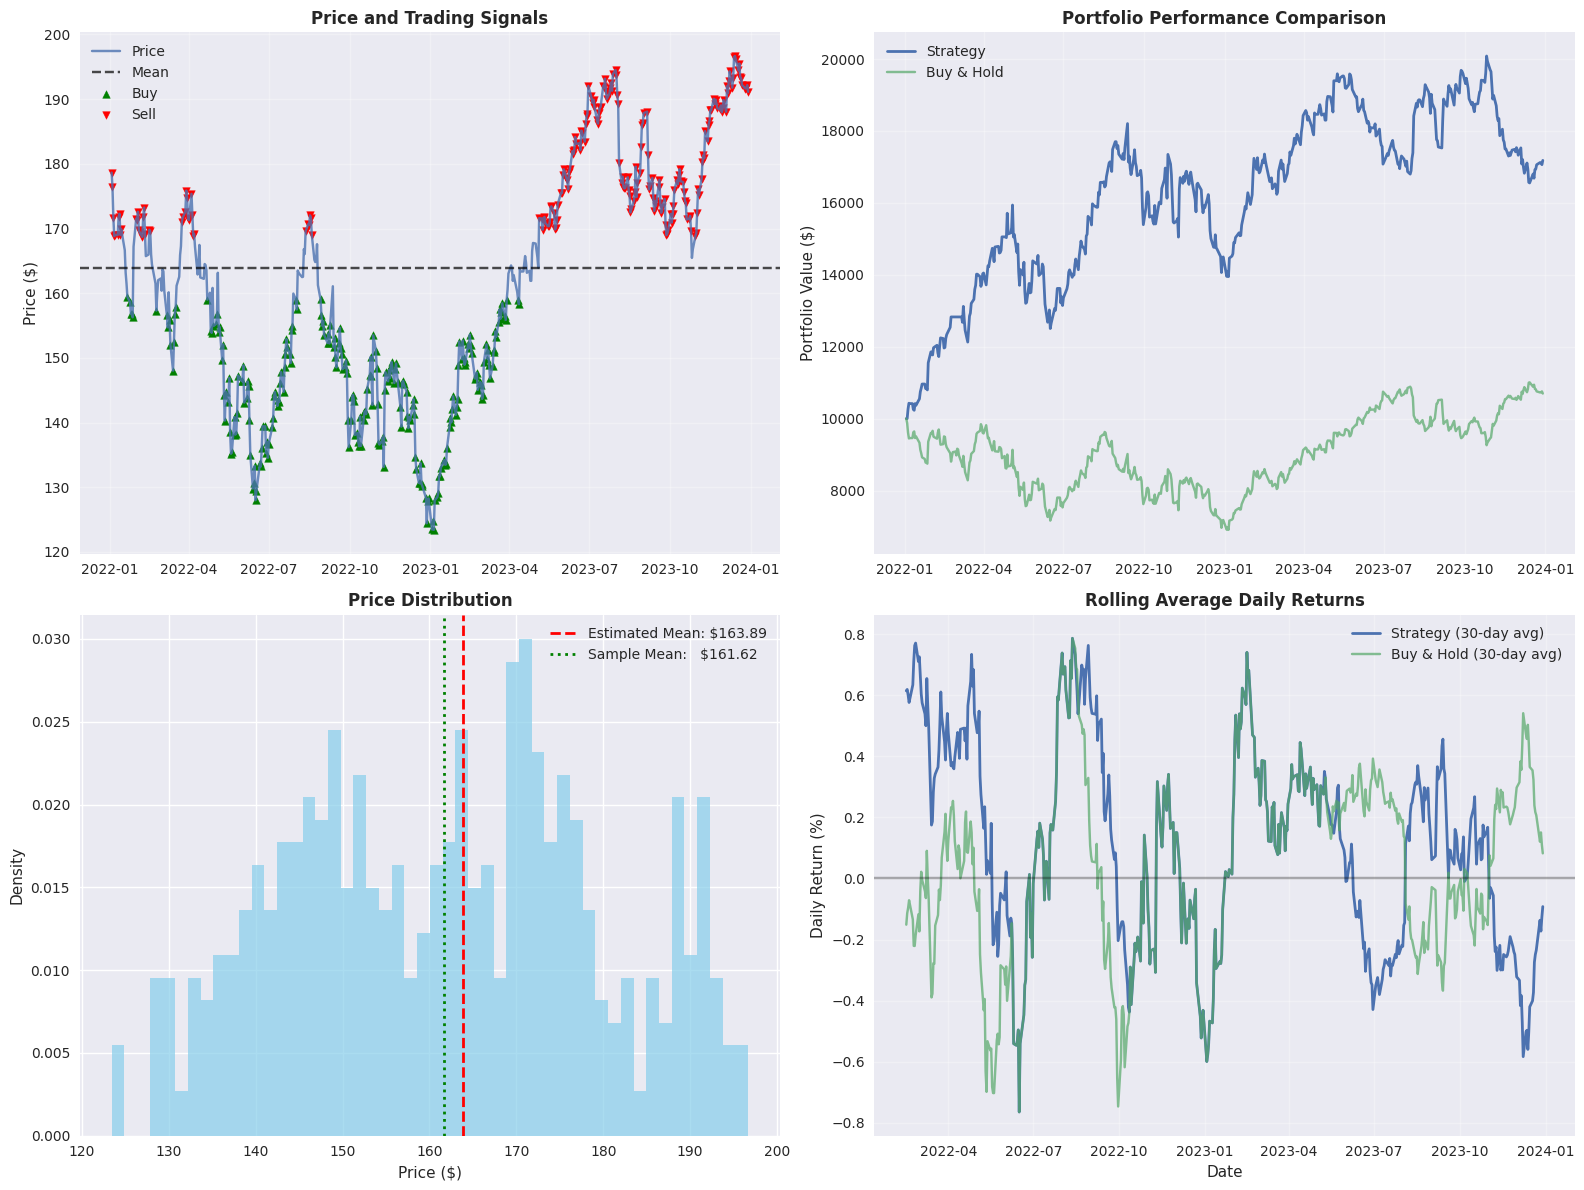

In [21]:
# 📊 Step 5 – Comprehensive Performance Visualization
# ---------------------------------------------------

# --- make sure price vectors are 1-D ---------------------------------------
prices_1d = np.asarray(prices, dtype=float).ravel()

# Buy-&-hold equity curve (same length as portfolio_values)
buy_hold_portfolio = initial_capital * (prices_1d / prices_1d[0])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1️⃣ Price series + signals
ax1.plot(data.index, prices_1d, label="Price", alpha=0.8)
ax1.axhline(mu_est, color="black", ls="--", alpha=0.7, label="Mean")

if buy_signals.any():
    ax1.scatter(data.index[buy_signals], prices_1d[buy_signals],
                c="green", marker="^", s=30, label="Buy")
if sell_signals.any():
    ax1.scatter(data.index[sell_signals], prices_1d[sell_signals],
                c="red", marker="v", s=30, label="Sell")

ax1.set_title("Price and Trading Signals", weight="bold")
ax1.set_ylabel("Price ($)")
ax1.legend();  ax1.grid(alpha=0.3)

# 2️⃣ Equity curves
ax2.plot(data.index, portfolio_values,      lw=2, label="Strategy")
ax2.plot(data.index, buy_hold_portfolio,    alpha=0.7, label="Buy & Hold")
ax2.set_title("Portfolio Performance Comparison", weight="bold")
ax2.set_ylabel("Portfolio Value ($)")
ax2.legend();  ax2.grid(alpha=0.3)

# 3️⃣ Price distribution
ax3.hist(prices_1d, bins=50, density=True, alpha=0.7, color="skyblue")
ax3.axvline(mu_est,         color="red",   ls="--", lw=2,
            label=f"Estimated Mean: ${mu_est:.2f}")
ax3.axvline(prices_1d.mean(), color="green", ls=":",  lw=2,
            label=f"Sample Mean:   ${prices_1d.mean():.2f}")
ax3.set_title("Price Distribution", weight="bold")
ax3.set_xlabel("Price ($)"); ax3.set_ylabel("Density")
ax3.legend()

# 4️⃣ Rolling 30-day returns
strategy_returns   = np.diff(portfolio_values)   / portfolio_values[:-1]   * 100
buy_hold_returns   = np.diff(buy_hold_portfolio) / buy_hold_portfolio[:-1] * 100

window = 30
strategy_rolling   = pd.Series(strategy_returns).rolling(window).mean()
buy_hold_rolling   = pd.Series(buy_hold_returns).rolling(window).mean()

ax4.plot(data.index[1:], strategy_rolling, lw=2,
         label="Strategy (30-day avg)")
ax4.plot(data.index[1:], buy_hold_rolling, alpha=0.7,
         label="Buy & Hold (30-day avg)")
ax4.axhline(0, color="black", alpha=0.3)
ax4.set_title("Rolling Average Daily Returns", weight="bold")
ax4.set_xlabel("Date"); ax4.set_ylabel("Daily Return (%)")
ax4.legend(); ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 📋 Summary and Next Steps

Let's create a comprehensive summary:

In [14]:
# 📋 Step 6 – Extra Metrics & Final Report
# ---------------------------------------

# --- flatten once ----------------------------------------------------------
prices_1d           = np.asarray(prices, dtype=float).ravel()
portfolio_values_1d = np.asarray(portfolio_values, dtype=float).ravel()
buy_hold_portfolio  = initial_capital * (prices_1d / prices_1d[0])

# --- returns ---------------------------------------------------------------
strategy_returns    = np.diff(portfolio_values_1d) / portfolio_values_1d[:-1]
buy_hold_returns    = np.diff(buy_hold_portfolio)  / buy_hold_portfolio[:-1]

# --- volatility & Sharpe ---------------------------------------------------
strategy_volatility = np.std(strategy_returns) * np.sqrt(252)
buy_hold_volatility = np.std(buy_hold_returns)   * np.sqrt(252)

strategy_sharpe = (total_return / 100) / strategy_volatility if strategy_volatility > 0 else 0
buy_hold_sharpe = (buy_hold_return / 100) / buy_hold_volatility if buy_hold_volatility > 0 else 0

# --- pretty print ----------------------------------------------------------
print("=" * 60)
print(f"📊 COMPREHENSIVE STRATEGY ANALYSIS – {TICKER}")
print("=" * 60)
print(f"📅 Period: {START_DATE} → {END_DATE}")
print(f"📈 Trading Days: {len(prices_1d)}")
print()
print("🔢 ORNSTEIN-UHLENBECK PARAMETERS:")
print(f"   μ  (Long-term mean)     : ${mu_est:.2f}")
print(f"   θ  (Mean-reversion speed): {theta_est:.4f}")
print(f"   σ  (Volatility)         : ${sigma_est:.2f}")
print(f"   Half-life               : {np.log(2) / theta_est:.1f} days")
print()
print("📊 TRADING ACTIVITY:")
print(f"   Buy signals             : {buy_signals.sum()} "
      f"({buy_signals.mean()*100:.1f}% of days)")
print(f"   Sell signals            : {sell_signals.sum()} "
      f"({sell_signals.mean()*100:.1f}% of days)")
print(f"   Total trades            : {len(trades)}")
print()
print("💰 PERFORMANCE COMPARISON:")
print(f"   Strategy Return         : {total_return:+.2f}%")
print(f"   Buy & Hold Return       : {buy_hold_return:+.2f}%")
print(f"   Excess Return           : {total_return - buy_hold_return:+.2f}%")
print()
print("⚡ RISK METRICS:")
print(f"   Strategy Volatility     : {strategy_volatility:.2f}")
print(f"   Buy & Hold Volatility   : {buy_hold_volatility:.2f}")
print(f"   Strategy Sharpe Ratio   : {strategy_sharpe:.2f}")
print(f"   Buy & Hold Sharpe Ratio : {buy_hold_sharpe:.2f}")
print()
print("✅ STRATEGY ASSESSMENT:")
if total_return > buy_hold_return:
    print("   🎯 Strategy OUTPERFORMED buy & hold")
else:
    print("   📉 Strategy UNDERPERFORMED buy & hold")

if strategy_sharpe > buy_hold_sharpe:
    print("   🏆 Strategy has BETTER risk-adjusted returns")
else:
    print("   ⚠️  Strategy has WORSE risk-adjusted returns")

print("=" * 60)
print("⚠️  DISCLAIMER: This is for educational purposes only.")
print("   Past performance does not guarantee future results.")
print("=" * 60)


📊 COMPREHENSIVE STRATEGY ANALYSIS – AAPL
📅 Period: 2022-01-01 → 2024-01-01
📈 Trading Days: 501

🔢 ORNSTEIN-UHLENBECK PARAMETERS:
   μ  (Long-term mean)     : $163.89
   θ  (Mean-reversion speed): 2.7019
   σ  (Volatility)         : $44.54
   Half-life               : 0.3 days

📊 TRADING ACTIVITY:
   Buy signals             : 228 (45.5% of days)
   Sell signals            : 201 (40.1% of days)
   Total trades            : 17

💰 PERFORMANCE COMPARISON:
   Strategy Return         : +71.81%
   Buy & Hold Return       : +6.99%
   Excess Return           : +64.82%

⚡ RISK METRICS:
   Strategy Volatility     : 0.29
   Buy & Hold Volatility   : 0.29
   Strategy Sharpe Ratio   : 2.47
   Buy & Hold Sharpe Ratio : 0.24

✅ STRATEGY ASSESSMENT:
   🎯 Strategy OUTPERFORMED buy & hold
   🏆 Strategy has BETTER risk-adjusted returns
⚠️  DISCLAIMER: This is for educational purposes only.
   Past performance does not guarantee future results.


## 🎮 Try Different Parameters!

Want to experiment? Go back and change:
- **TICKER**: Try different stocks (MSFT, GOOGL, TSLA, etc.)
- **Date ranges**: Different time periods
- **threshold_multiplier**: More or less sensitive signals

## 🚀 Next Steps

1. **Improve the strategy**: Add transaction costs, better risk management
2. **Test on more assets**: Portfolio of mean-reverting stocks
3. **Real-time implementation**: Connect to live data feeds
4. **Machine learning**: Use ML to optimize parameters

## 📚 Learn More

- [Ornstein-Uhlenbeck Process Theory](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process)
- [Mean Reversion in Finance](https://www.investopedia.com/terms/m/meanreversion.asp)

---
